In [ ]:
# link & mount to google drive to import data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

**Load in data**

#### Old con dataframe

In [ ]:
# import pre-processed data from google drive and store in dataframe using pandas function
# split the dataset into 6 different datasets, one for each class
# GAN model will generate samples for one class at a time, therefore dataframe needs to be split by class. Will be joined again after all samples have been generated.

d_Botnet = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/35/d_Botnet35.csv')
d_Bruteforce = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/35/d_BruteForce35.csv')

**Drop label category from each dataframe**

In [ ]:
#colonna superflua perché tanto ho già diviso per classi... la label di ogni df è uguale obv

dfBotnet = d_Botnet.drop(['L_BENIGN','L_Infiltration_Portscan','L_DDoS','L_DoS','L_BruteForce','L_Botnet'], axis=1)
dfBruteforce = d_Botnet.drop(['L_BENIGN','L_Infiltration_Portscan','L_DDoS','L_DoS','L_BruteForce','L_Botnet'], axis=1)

In [ ]:
df = dfBotnet #dfBruteforce

In [ ]:
pd.options.display.float_format = '{:,.20f}'.format

```
BENIGN                   1594422
Infiltration_Portscan     230853
DoS                       171620
DDoS                       95133
BruteForce                  7005
Botnet                       736
```


## **Define model architecture**

model architecture adapted from https://github.com/ydataai/ydata-synthetic - a model for generating credit card data

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
# Allow matplotlib images to render immediately.
%matplotlib inline

import seaborn as sns

from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras import Model

In [ ]:
!pip install sdv
from sdv.evaluation.single_table import get_column_plot
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import evaluate_quality
from sdv.evaluation.single_table import run_diagnostic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.0/140.0 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.9/74.9 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.7/170.7 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 83.9 MB/s eta 0:00:00


Modello GAN

In [ ]:
def plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist):
 # plot loss
 plt.subplot(2, 1, 1)
 plt.plot(d1_hist, label='d-loss-real')
 plt.plot(d2_hist, label='d-loss-fake')
 plt.plot(g_hist, label='g-loss')
 plt.legend()
 # plot discriminator accuracy
 plt.subplot(2, 1, 2)
 plt.plot(a1_hist, label='acc-real')
 plt.plot(a2_hist, label='acc-fake')
 plt.legend()

 plt.show()



1.   Alpha (for LeakyReLU):
> * alpha is the slope of the negative part of the LeakyReLU activation function. It helps introduce a small, non-zero slope to the activation function for negative input values, preventing the neuron from being completely inactive.
> * A common value for alpha is in the range of 0.01 to 0.3. You can experiment with different values to see what works best for your specific dataset and model.

2.   Momentum (for Batch Normalization):
> * momentum is a parameter used in the update of the moving averages in batch normalization. It controls the contribution of the previous running mean and variance to the new estimates.
> * Common values for momentum are between 0.9 and 0.999. Higher values give more weight to the new batch, and lower values give more weight to the history.

3.   Dropout Rate (for Discriminator):
> * rate is the dropout rate, which represents the fraction of input units to drop during training.
> * A common value for rate is between 0.3 and 0.5. This means dropping 30% to 50% of the input units during training.





In [ ]:
alpha_leakyRelu = 0.2 #@param
momentumBN = 0.8 #@param
dropoutRate = 0.1 #@param

In [ ]:
#classe del modello intero GAN
class GAN():


    def __init__(self, gan_args):
        [self.batch_size, lr_d, lr_g, self.noise_dim,
         self.data_dim, layers_dim] = gan_args

        self.generator = Generator(self.batch_size).\
            build_model(input_shape=(self.noise_dim,), dim=layers_dim, data_dim=self.data_dim)

        self.discriminator = Discriminator(self.batch_size).\
            build_model(input_shape=(self.data_dim,), dim=layers_dim)

        #Optimizers
        optimizer_discriminator = tf.keras.optimizers.Adam(lr_d, 0.5)
        optimizer_generator = tf.keras.optimizers.Adam(lr_g, 0.5)

        # Build and compile the discriminator
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer_discriminator,
                                   metrics=['accuracy'])

        # The generator takes noise as input and generates samples
        z = Input(shape=(self.noise_dim,))
        record = self.generator(z)

        # For the combined model only the generator is trained
        self.discriminator.trainable = False

        # The discriminator takes generated samples as input and determines validity
        validity = self.discriminator(record)

        # The combined model
        # Trains the generator to try and create samples that will fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer_generator)

    def get_data_batch(self, train, batch_size, seed=0):
        start_i = (batch_size * seed) % len(train)
        stop_i = start_i + batch_size
        shuffle_seed = (batch_size * seed) // len(train)
        np.random.seed(shuffle_seed)
        train_ix = np.random.choice(list(train.index), replace=False, size=len(train))  # wasteful to shuffle every time
        train_ix = list(train_ix) + list(train_ix)  # duplicate to cover ranges past the end of the set
        x = train.loc[train_ix[start_i: stop_i]].values
        return np.reshape(x, (batch_size, -1))

    def print_architecture(self):
      print("Generator Architecture:")
      self.generator.summary()
      print("\nDiscriminator Architecture:")
      self.discriminator.summary()
      print("\nCombined Model Architecture:")
      self.combined.summary()
      print("\n====================================================================================\n")


    def train(self, data, train_arguments):
        [cache_prefix, epochs, sample_interval] = train_arguments

        # Adversarial ground truths
        valid = np.ones((self.batch_size, 1))
        fake = np.zeros((self.batch_size, 1))

        d1_hist, d2_hist, g_hist, a1_hist, a2_hist = list(), list(), list(), list(), list()

        for epoch in range(epochs):
            # Discriminator
            batch_data = self.get_data_batch(data, self.batch_size)
            noise = tf.random.normal((self.batch_size, self.noise_dim))

            # Generate a batch of new samples
            gen_data = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real, d_acc1 = self.discriminator.train_on_batch(batch_data, valid)
            d_loss_fake, d_acc2 = self.discriminator.train_on_batch(gen_data, fake)
            #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Generator
            noise = tf.random.normal((self.batch_size, self.noise_dim))
            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            #Therefore, using the loss values directly is not recommended in GANs.
            #Instead, metrics such as the Inception Score, Frechet Inception Distance (FID score),
            #and perceptual similarity measures (LPIPS) are used for interpreting the results.
            #PERFORMANCE
            d1_hist.append(d_loss_real)
            d2_hist.append(d_loss_fake)
            g_hist.append(g_loss)
            a1_hist.append(d_acc1)
            a2_hist.append(d_acc2)
            # Plot the progress
            print('==>> %d, dRLoss=%.3f, dFLoss=%.3f gLoss=%.3f, accR=%d, accF=%d' % (epoch, d_loss_real, d_loss_fake, g_loss, int(100*d_acc1), int(100*d_acc2)))
        plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist)


#DISCRIMINATORE
class Discriminator():
    def __init__(self,batch_size):
        self.batch_size=batch_size

    def build_model(self, input_shape, dim):
        input = Input(shape=input_shape, batch_size=self.batch_size)
        x = Dense(dim * 4)(input)
        x = LeakyReLU(alpha=alpha_leakyRelu)(x)
        x = Dropout(dropoutRate)(x)
        x = Dense(dim * 2)(x)
        x = LeakyReLU(alpha=alpha_leakyRelu)(x)
        x = Dropout(dropoutRate)(x)
        x = Dense(dim)(x)
        x = LeakyReLU(alpha=alpha_leakyRelu)(x)
        x = Dense(1, activation='sigmoid')(x)
        return Model(inputs=input, outputs=x)


#Generatore
class Generator():
    def __init__(self, batch_size):
        self.batch_size = batch_size

    def build_model(self, input_shape, dim, data_dim):
        input_layer = Input(shape=input_shape, batch_size=self.batch_size)
        x = Dense(dim)(input_layer)
        x = LeakyReLU(alpha=alpha_leakyRelu)(x)
        x = BatchNormalization(momentum=momentumBN)(x)
        x = Dense(dim * 2)(x)
        x = LeakyReLU(alpha=alpha_leakyRelu)(x)
        x = BatchNormalization(momentum=momentumBN)(x)
        x = Dense(dim * 4)(x)
        x = LeakyReLU(alpha=alpha_leakyRelu)(x)
        x = BatchNormalization(momentum=momentumBN)(x)
        output_layer = Dense(data_dim, activation='sigmoid')(x) # Use sigmoid activation in the output layer to constrain values to [0, 1]
        return Model(inputs=input_layer, outputs=output_layer)

Batch Normalization (BN) and dropout are techniques that serve different purposes:

* Batch Normalization (BN):
> BN is often used to normalize the activations in a layer, which can help with training stability and speed up convergence. It is particularly useful in deep neural networks.
In the generator, BN can help with avoiding mode collapse and ensuring that the generator learns a diverse set of samples.



* Dropout:
> Dropout is a regularization technique where randomly selected neurons are ignored during training. It helps prevent overfitting by introducing noise and reducing reliance on specific neurons.
In the discriminator, dropout can help prevent the discriminator from becoming too specialized to the training data and encourage the learning of more robust features.


While BN and dropout are commonly used in GANs, they are not mandatory.

#### Self-attention Generator

In [ ]:
!pip install keras-self-attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=773a7ccb868c7b2d15bcfac92837aa5e5ca57d580e540728201a77675b720f1a
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


In [ ]:
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization, Reshape
from tensorflow.keras.models import Model

from keras_self_attention import SeqSelfAttention

In [ ]:
#SELF-ATTENTION GENERATOR
class Generator():
    def __init__(self, batch_size):
        self.batch_size = batch_size

    def build_model(self, input_shape, dim, data_dim):
        input_layer = Input(shape=input_shape, batch_size=self.batch_size)
        x = Dense(dim)(input_layer)
        x = LeakyReLU(alpha=alpha_leakyRelu)(x)
        x = BatchNormalization(momentum=momentumBN)(x)
        x = Dense(dim * 2)(x)
        x = LeakyReLU(alpha=alpha_leakyRelu)(x)
        x = BatchNormalization(momentum=momentumBN)(x)
        x = Dense(dim * 4)(x)

        # Reshape for self-attention layer
        x_reshaped = Reshape((dim * 4, 1))(x)

        # Add Self-Attention layer
        x_attended = SeqSelfAttention(attention_activation='sigmoid')(x_reshaped)

        # Reshape back to original shape
        x_attended = Reshape((dim * 4,))(x_attended)

        x = LeakyReLU(alpha=alpha_leakyRelu)(x_attended)
        x = BatchNormalization(momentum=momentumBN)(x)
        output_layer = Dense(data_dim, activation='sigmoid')(x)

        return Model(inputs=input_layer, outputs=output_layer)


## Training & Generazione

**Generating class data**

```
BENIGN                   1594422
Infiltration_Portscan     230853
DoS                       171620
DDoS                       95133
BruteForce                  7005
Botnet                       736
```




```
Given that your original data has 35 features
--> you might want to experiment with sizes around 35 or slightly larger <--
to ensure that the input noise vector captures additional variations while respecting the underlying structure of the data
```



In [ ]:
data_columns = df.columns
df[data_columns] = df[data_columns]

#generator parameters
batch_size = 1024 #@param
lr_d=0.0001 #@param
lr_g=0.0003 #@param
input_noise = 16  #@param

input_shape=35 #numeroFeatures
dim=128 #@param


#training parameters
epochs = 6500 #@param
log_step = 100

In [ ]:
generator_parameters = [batch_size, lr_d, lr_g, input_noise, input_shape, dim]
training_parameters = ['', epochs, log_step]

## Training

In [ ]:
synthesizer = GAN(generator_parameters)
#synthesizer.print_architecture()

Output streaming troncato alle ultime 5000 righe.
16/16 [==============================] - 0s 1ms/step
==>> 5000, dRLoss=0.698, dFLoss=0.696 gLoss=0.704, accR=49, accF=46
16/16 [==============================] - 0s 2ms/step
==>> 5001, dRLoss=0.695, dFLoss=0.697 gLoss=0.705, accR=49, accF=45
16/16 [==============================] - 0s 1ms/step
==>> 5002, dRLoss=0.695, dFLoss=0.693 gLoss=0.708, accR=51, accF=48
16/16 [==============================] - 0s 1ms/step
==>> 5003, dRLoss=0.692, dFLoss=0.693 gLoss=0.710, accR=53, accF=51
16/16 [==============================] - 0s 1ms/step
==>> 5004, dRLoss=0.694, dFLoss=0.696 gLoss=0.708, accR=50, accF=46
16/16 [==============================] - 0s 1ms/step
==>> 5005, dRLoss=0.695, dFLoss=0.704 gLoss=0.700, accR=49, accF=40
16/16 [==============================] - 0s 1ms/step
==>> 5006, dRLoss=0.691, dFLoss=0.698 gLoss=0.705, accR=50, accF=47
16/16 [==============================] - 0s 1ms/step
==>> 5007, dRLoss=0.698, dFLoss=0.692 gLoss=0.706,

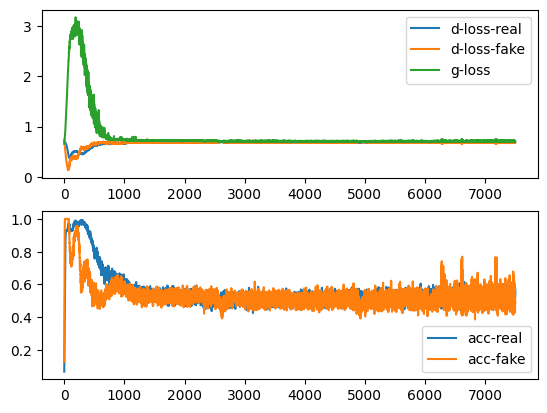

In [ ]:
synthesizer.train(df, training_parameters)

In [ ]:
models = {'GAN': ['GAN', False, synthesizer.generator]}



```
By setting a seed, you can ensure that the randomness introduced
by the use of random number generators is consistent across different runs of your code,
which can help make your results more reliable and reproducible
```



In [ ]:
np.random.seed(3) # used for retestability

num_rows_gen = 1000 #quante righe verranno generate generate
noise = np.random.normal(0, 1, (num_rows_gen, input_noise))

[model_name, with_class, generator_model] = models['GAN']

X = generator_model.predict(noise)

32/32 [==============================] - 0s 3ms/step


In [ ]:
# Create a dataframe with generated samples, so can be used for evaluation later
gen_samples = pd.DataFrame(X, columns=data_columns)

In [ ]:
print(df.shape)
print(gen_samples.shape)

(736, 35)
(1000, 35)


In [ ]:
df.head()

,FlowDuration,BwdPacketLengthStd,PacketLengthVariance,DstPort,TotalLengthofFwdPacket,PacketLengthStd,FlowIATMax,FlowPackets/s,FwdPacketLengthMax,BwdPacketLengthMax,...,FwdHeaderLength,FlowIATMean,BwdHeaderLength,FwdRSTFlags,FWDInitWinBytes,BwdInitWinBytes,FwdIATMax,BwdPackets/s,ACKFlagCount,FwdSegSizeMin
0,0.00059517501487930003,0.00952985313655499953,0.00024119236370999999,0.12330418593294570351,0.00001507351992797033,0.01553036907836040023,0.00056911792821139995,0.00004199553134229017,0.00781627719580980061,0.00655401945724520037,...,0.50140552432168172814,0.00012938038134279999,0.50204755210561702317,0.00000000000000000000,0.12500190737773708705,0.00361638818951700008,0.00058202563537790004,0.00002800257623701380,0.00001563474117663153,0.45454545454545458583
1,0.00104414169277020010,0.00952985313655499953,0.00024845658615930001,0.12330418593294570351,0.00001538431415328931,0.01576250570687669911,0.00102344393530069992,0.00002393458691479384,0.00797743755036259966,0.00655401945724520037,...,0.50140552432168172814,0.00022698179030459999,0.50204755210561702317,0.00000000000000000000,0.12500190737773708705,0.00361638818951700008,0.00103257612722890005,0.00001596194671902185,0.00001563474117663153,0.45454545454545458583
2,0.00077073335260160005,0.00952985313655499953,0.00024119236370999999,0.12330418593294570351,0.00001507351992797033,0.01553036907836040023,0.00074772665746070002,0.00003242795662797918,0.00781627719580980061,0.00655401945724520037,...,0.50140552432168172814,0.00016754522065160000,0.50204755210561702317,0.00000000000000000000,0.12500190737773708705,0.00361638818951700008,0.00076020082988589996,0.00002162419314729319,0.00001563474117663153,0.45454545454545458583
3,0.00061930001548249998,0.00952985313655499953,0.00024299328552560001,0.12330418593294570351,0.00001515121848430008,0.01558824189976630060,0.00059676798950229998,0.00004035928138168117,0.00785656728444799994,0.00655401945724520037,...,0.50140552432168172814,0.00013462494439400000,0.50204755210561702317,0.00000000000000000000,0.12500190737773708705,0.00361638818951700008,0.00060753399655789995,0.00002691174293903145,0.00001563474117663153,0.45454545454545458583
4,0.00052496667979080001,0.00952985313655499953,0.00024299328552560001,0.12330418593294570351,0.00001515121848430008,0.01558824189976630060,0.00050268444761709995,0.00004761298233431034,0.00785656728444799994,0.00655401945724520037,...,0.50140552432168172814,0.00011411770648759999,0.50204755210561702317,0.00000000000000000000,0.12500190737773708705,0.00361638818951700008,0.00051265055964349996,0.00003174754353381907,0.00001563474117663153,0.45454545454545458583


In [ ]:
gen_samples.head()

,FlowDuration,BwdPacketLengthStd,PacketLengthVariance,DstPort,TotalLengthofFwdPacket,PacketLengthStd,FlowIATMax,FlowPackets/s,FwdPacketLengthMax,BwdPacketLengthMax,...,FwdHeaderLength,FlowIATMean,BwdHeaderLength,FwdRSTFlags,FWDInitWinBytes,BwdInitWinBytes,FwdIATMax,BwdPackets/s,ACKFlagCount,FwdSegSizeMin
0,0.00025702457060106099,0.00938260834664106369,0.00076729315333068371,0.12231414020061492920,0.00000727923406884656,0.01654149964451789856,0.00077167368726804852,0.00002826187665050384,0.00853542424738407135,0.00715462118387222290,...,0.50394195318222045898,0.00006110888352850452,0.50263047218322753906,0.00000024561543909840,0.12303416430950164795,0.00324506871402263641,0.00036191265098750591,0.00000449898561782902,0.00001365526077279355,0.45394709706306457520
1,0.00025400498998351395,0.00944950990378856659,0.00084502960089594126,0.12339460104703903198,0.00000638759456705884,0.01729729771614074707,0.00077405333286151290,0.00002198055517510511,0.00989549420773983002,0.00644907727837562561,...,0.50473713874816894531,0.00005120034984429367,0.50434798002243041992,0.00000018668389145660,0.12411770224571228027,0.00286609004251658916,0.00030488293850794435,0.00000310332916342304,0.00001052333846018882,0.45524379611015319824
2,0.00040564360097050667,0.00922080688178539276,0.00036441284464672208,0.12296662479639053345,0.00000614300279266899,0.01575735397636890411,0.00079004518920555711,0.00004093027746421285,0.00828297622501850128,0.00698942691087722778,...,0.50310170650482177734,0.00009295914060203359,0.50215017795562744141,0.00000041746568513190,0.12412500381469726562,0.00288548297248780727,0.00040113786235451698,0.00000723085668141721,0.00004100853402633220,0.45297813415527343750
3,0.00070514471735805273,0.00947312358766794205,0.00012226479884702712,0.12259364128112792969,0.00000368170935871603,0.01533555425703525543,0.00063316011801362038,0.00003627988917287439,0.00722896773368120193,0.00709584774449467659,...,0.50064533948898315430,0.00013303152809385210,0.50076055526733398438,0.00000083944883044751,0.12388821691274642944,0.00330662820488214493,0.00058008177438750863,0.00000979057585936971,0.00008639577572466806,0.45290076732635498047
4,0.00039896179805509746,0.00940640270709991455,0.00140943401493132114,0.12423148751258850098,0.00001471312771172961,0.02204113826155662537,0.00098437548149377108,0.00002829712684615515,0.01198175176978111267,0.00569789484143257141,...,0.50534647703170776367,0.00006411604408640414,0.50338017940521240234,0.00000044982292024542,0.12353011220693588257,0.00299246609210968018,0.00047095009358599782,0.00000645730733594974,0.00001787329165381379,0.45592194795608520508


#Valutazione

Text(0.5, 1.0, 'Dati generati')

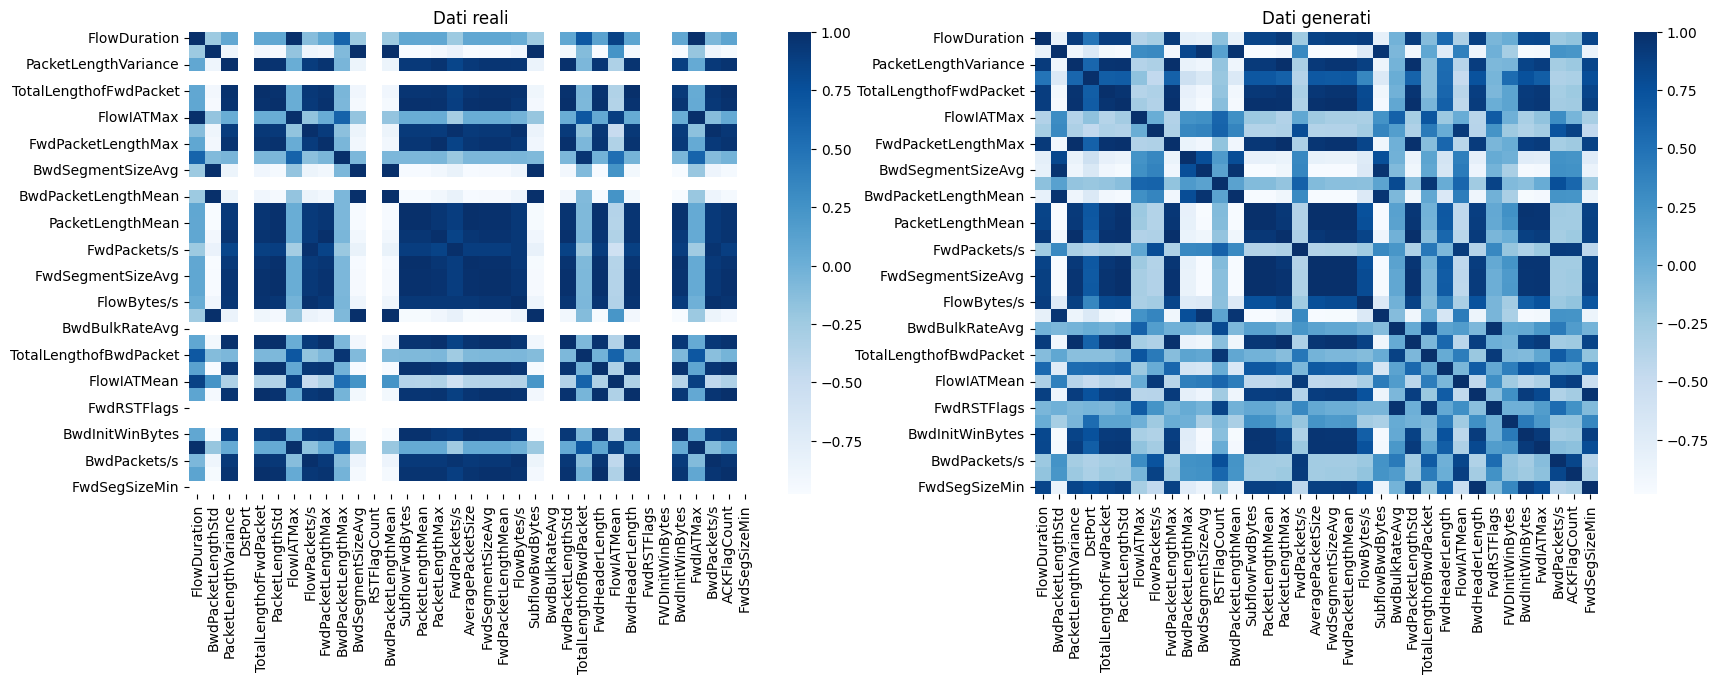

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.heatmap(df.corr(), annot=False, ax=ax[0], cmap="Blues")
sns.heatmap(gen_samples.corr(), annot=False, ax=ax[1], cmap="Blues")
ax[0].set_title("Dati reali")
ax[1].set_title("Dati generati")

In [ ]:
real_data = df.to_numpy()
generated_data = gen_samples.to_numpy()

In [ ]:
from scipy.stats import wasserstein_distance

# Flatten the arrays for 1D distribution
real_flat = real_data.flatten()
generated_flat = generated_data.flatten()

# Compute Wasserstein distance
w_distance = wasserstein_distance(real_flat, generated_flat)

print('Wasserstein Distance delle distribuzioni:', w_distance)

Wasserstein Distance delle distribuzioni: 0.001968770437444054




```
Interpretation can depend on the scale and nature of your data, but in general:
## Closer to 0: Indicates a smaller difference between distributions.
```



In [ ]:
real = df['FlowDuration'].to_numpy()
gen = gen_samples['FlowDuration'].to_numpy()

w_dist_feature = wasserstein_distance(real, gen)
print("Wasserstein Distance per la feature FlowDuration:", w_dist_feature)

Wasserstein Distance per la feature FlowDuration: 0.0008388901533099985




```
# Wasserstein Distance for BwdPacketLengthStd feature: 0.0008046525194385199
# Wasserstein Distance for FlowDuration feature: 0.0003101878491190463
# Wasserstein Distance for PacketLengthVariance feature: 0.023556970948095415
# Wasserstein Distance for DstPort feature: 0.0016220070848744499
```



In [ ]:
from scipy.stats import ks_2samp


column_to_check = 0

# Perform the KS test for the selected column
ks_statistic, ks_p_value = ks_2samp(real_data[:, column_to_check], generated_data[:, column_to_check])

# Print the results
print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {ks_p_value}")

# Interpret the results
#A higher alpha means you are more lenient in terms of what level of evidence you require to reject the null hypothesis.
alpha = 0.1  # significance level
if ks_p_value > alpha:
    print("Le distribuzioni sono simili (fail to reject the null hypothesis)")
else:
    print("Le distribuzioni sono differenti (reject the null hypothesis)")

KS Statistic: 0.22702173913043477
P-value: 1.2028778866845914e-19
Le distribuzioni sono differenti (reject the null hypothesis)


In [ ]:
# Choose the column you want to check
# 0 = FlowDuration
# 1 = BwdPacketLengthStd
# 2 = PacketLengthVariance
# 3 = DstPort

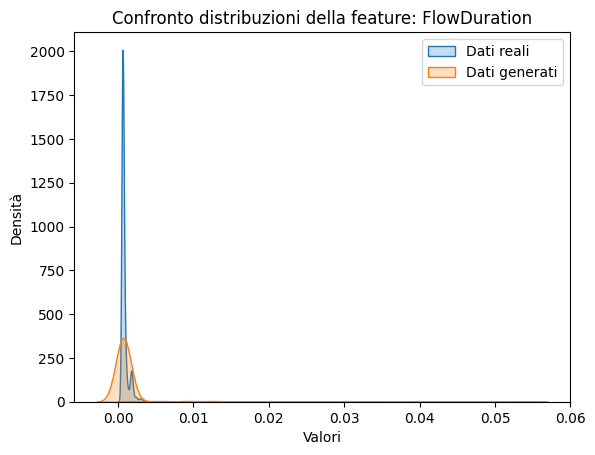

In [ ]:
column_to_compare = 0

# Extract the selected column for each array
real_column = real_data[:, column_to_compare]
generated_column = generated_data[:, column_to_compare]

# Plot the KDE for both distributions
sns.kdeplot(real_column, label='Dati reali', fill=True)
sns.kdeplot(generated_column, label='Dati generati', fill=True)

# Add labels and legend
plt.title(f'Confronto distribuzioni della feature: {df.columns[column_to_compare]}')
plt.xlabel('Valori')
plt.ylabel('Densità')
plt.legend()
#salva in Drive
#images_dir = '/content/drive/MyDrive/Colab Notebooks/progettoTesi/grafici_pdf'
#plt.savefig(f"{images_dir}/distributionFeatureFlowDuration_genWGAN_t2.pdf", dpi=200, format='pdf') ###!!!!!!!!!!!!!! CAMBIARE TENTATIVI CON N°
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

real_data_first_column = real_data[:, 0]
gen_data_first_column = generated_data[:, 0]

# Downsample gen_data_first_column to match the size of real_data_first_column - 736
downsampled_gen_data_first_column = np.random.choice(gen_data_first_column, size=(len(real_data_first_column),), replace=False)

# Calculate the Mean Squared Error
mse = mean_squared_error(real_data_first_column, downsampled_gen_data_first_column)

print(f"Mean Squared Error: {mse}")

Mean Squared Error: 1.3235213258466927e-05




```
# 0 --> Mean Squared Error: 2.803826646413654e-07
# 1 --> Mean Squared Error: 3.4297804631933104e-06
# 2 --> Mean Squared Error: 0.011631663888692856
# 3 --> Mean Squared Error: 4.149306732870173e-06
```





```
Interpretation:

*   A smaller MSE indicates that the generated data is closer to the real data in terms of the selected feature.
*  Closer to 0 suggests better performance for that specific feature.


```



In [ ]:
def gaussian_kernel(x, y, sigma=1.0):
    # Gaussian kernel function
    return np.exp(-np.linalg.norm(x - y) ** 2 / (2 * (sigma ** 2)))

def mmd(real_data, generated_data, kernel=gaussian_kernel):
    m = len(real_data)
    n = len(generated_data)

    # Compute the MMD statistic
    mmd_statistic = 0.0
    for i in range(m):
        for j in range(m):
            mmd_statistic += kernel(real_data[i], real_data[j])

    for i in range(n):
        for j in range(n):
            mmd_statistic += kernel(generated_data[i], generated_data[j])

    for i in range(m):
        for j in range(n):
            mmd_statistic -= 2 * kernel(real_data[i], generated_data[j])

    mmd_statistic /= (m * (m - 1)) + (n * (n - 1)) - 2 * m * n
    return mmd_statistic


mmd_statistic = mmd(real_data[:, 0], generated_data[:, 0])

print("MMD:", mmd_statistic)

MMD: 1.025490904993554




```
you would want the MMD to be close to zero, as it implies that the generated samples are very similar to the real data.

Negative MMD: The MMD itself doesn't have a fixed sign, so negative values are not uncommon. The magnitude is more important,
and in this case, the small magnitude indicates similarity.
```



Text(0.5, 1.0, 'Dati generati')

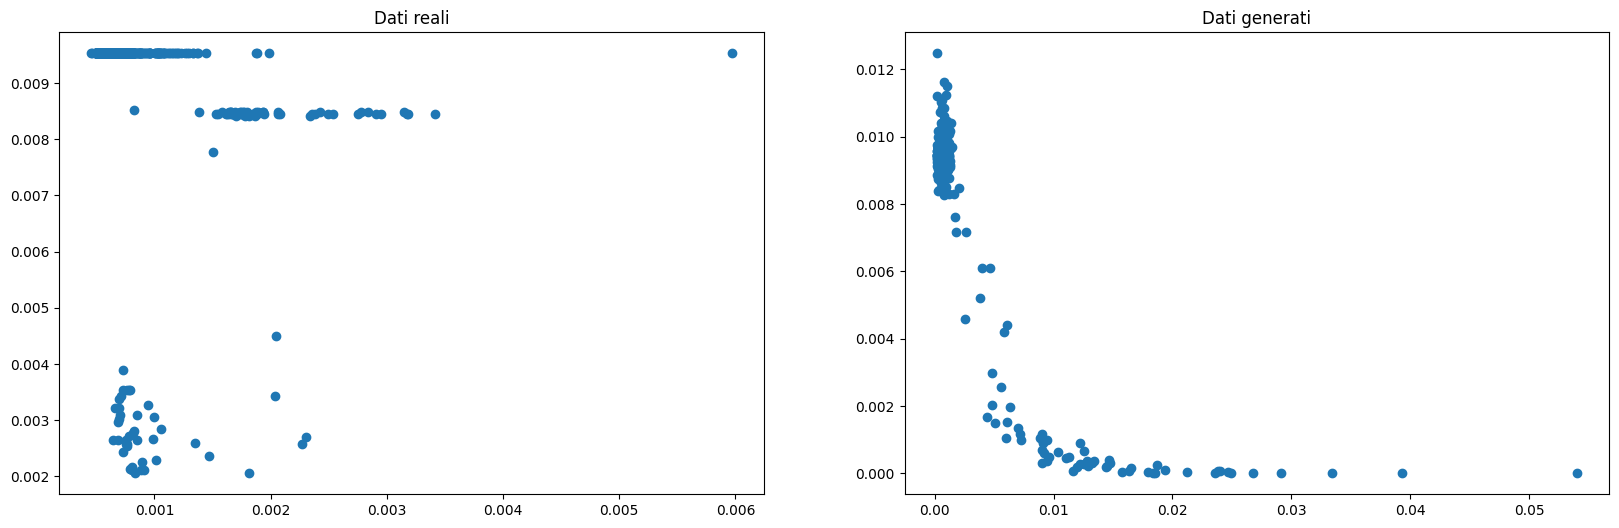

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].scatter(df.iloc[:, 0], df.iloc[:, 1])
ax[1].scatter(gen_samples.iloc[:, 0], gen_samples.iloc[:, 1])
ax[0].set_title("Dati reali")
ax[1].set_title("Dati generati")

#Vecchi metodi valutazione
*   https://github.com/sdv-dev/SDV
*   https://docs.sdv.dev/sdv



In [ ]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df)

In [ ]:
quality_report = evaluate_quality(
    real_data=df,
    synthetic_data=gen_samples,
    metadata=metadata)

Generating report ...
(2/2) Evaluating Column Pair Trends: :  97%|█████████▋| 578/595 [00:56<00:04,  4.20it/s]

In [ ]:
diagnostic_report = run_diagnostic(
    real_data=df,
    synthetic_data=gen_samples,
    metadata=metadata)